In [1]:
using rhd2000evalboard, HDF5, rhd2000registers

In [2]:
#Opal Kelly XEM6010 board
open_board()

# Load Rhythm FPGA configuration bitfile (provided by Intan Technologies).
uploadFpgaBitfile();

#Initialize board
initialize_board()

#For 64 channel I think you do this twice (not positive but we can test)
enableDataStream(1, true)
setDataSource(0, 0) #port A MISO1
setDataSource(1, 8) #port A MISO1 DDR
println(rhd2000evalboard.dataStreamEnabled)
println(rhd2000evalboard.numDataStreams)

#Select per-channel amplifier sampling rate
setSampleRate(20000)

#Now that we have set our sampling rate, we can set the MISO sampling delay
#which is dependent on the sample rate. We assume a 3-foot cable.
setCableLengthFeet("PortA", 6.0)

# Let's turn one LED on to indicate that the program is running.
ledArray=[1,1,0,0,0,0,0,0]
setLedDisplay(ledArray)

Scanning USB for Opal Kelly devices...
Found 1 Opal Kelly device(s)
Serial number of device 0 is 141100085D
FPGA configuration loaded.
Rhythm configuration file successfully loaded. Rhythm version number: 1
[1 1 0 0 0 0 0 0]
2
3


In [3]:
#Set up an RHD2000 register object using this sample rate 
#to optimize MUX-related register settings.
r=CreateRHD2000Registers(20000.0)

#First, let's create a command list for the AuxCmd1 slot.  This command
#sequence will create a 1 kHz, full-scale sine wave for impedance testing.

#Next, we'll create a command list for the AuxCmd2 slot.  This command sequence
#will sample the temperature sensor and other auxiliary ADC inputs.

#For the AuxCmd3 slot, we will create two command sequences.  Both sequences
#will configure and read back the RHD2000 chip registers, but one sequence will
#also run ADC calibration.

#Before generating register configuration command sequences, set amplifier
#bandwidth paramters.


#Upload version with no ADC calibration to AuxCmd3 RAM Bank 0.
commandList=createCommandListRegisterConfig(zeros(Int32,1),false,r)
uploadCommandList(commandList, "AuxCmd3", 0)

#Upload version with ADC calibration to AuxCmd3 RAM Bank 1.
commandList=createCommandListRegisterConfig(zeros(Int32,1),true,r)
uploadCommandList(commandList, "AuxCmd3", 1)

selectAuxCommandLength("AuxCmd3", 0, length(commandList) - 1)

#Select RAM Bank 1 for AuxCmd3 initially, so the ADC is calibrated.
selectAuxCommandBank("PortA", "AuxCmd3", 1);

setMaxTimeStep(60)
setContinuousRunMode(false)
run()

while (isRunning())
end

flush()

selectAuxCommandBank("PortA", "AuxCmd3", 0)

In [4]:
#short sequence
setMaxTimeStep(20000) #4140 causes error
setContinuousRunMode(false)
mytime=zeros(Int32,2)
electrode=[i => zeros(Int32,2) for i = 1:(2*32)]
saveOut="test.jld"
h5open(saveOut, "w") do myfile
    d=d_create(myfile, "time", Int32, ((1,),(-1,)), "chunk", (100,))
    d[1]=1
    for i=1:64
        e=d_create(myfile, string(i), Int32, ((1,),(-1,)),"chunk", (100,))
    end
end

run()

usbDataRead=true

true

In [6]:
@time usbDataRead=readDataBlocks(1,mytime,electrode)

elapsed time: 0.003460368 seconds (2489368 bytes allocated)


true

In [8]:
@time numWordsInFifo() 

elapsed time: 0.001203343 seconds (96 bytes allocated)


0x00000000001ab1c0

In [5]:
run()

while (usbDataRead || isRunning())
    #If Fifo contains words, they are read
    usbDataRead = readDataBlocks(1,mytime,electrode)
    if (length(mytime) >= 3000)
        (mytime, electrode) = queueToFile(mytime,electrode,saveOut)
    end
    
end

mytime = queueToFile(mytime,electrode,saveOut)

flush()

In [8]:
using PyPlot

INFO: Loading help data...


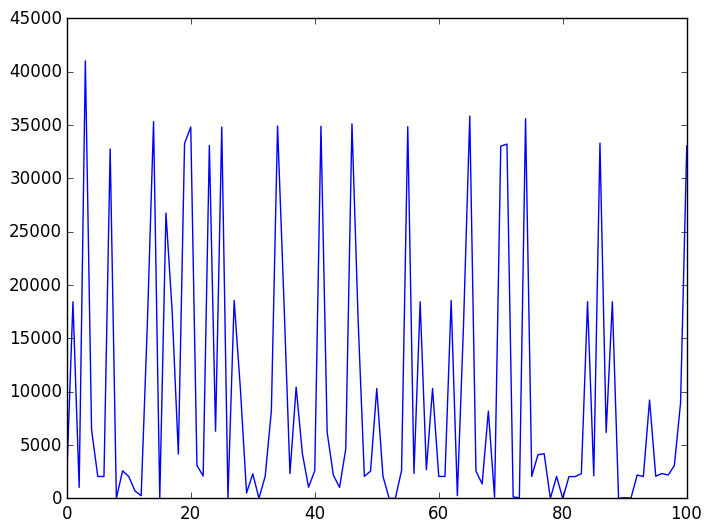

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9dd7938a10>

In [13]:
h5open(saveOut) do hi
    e=d_open(hi, "45")
    plot(e[2900:3000])
end